# MPS classifier using TensorNetwork

In this notebook we implement one of the simplest, yet still quite powerful, tensor network structure called Matrix Product State (MPS). We follow the algorithm as outlined in [this paper](https://papers.nips.cc/paper/6211-supervised-learning-with-tensor-networks.pdf) by Stoudenmire and Schwab (see also [my notes](tensor_network_notes.pdf) for a quick summary). The code here is not optimized to run at large scale and it is just an illustration of how the algorithm works for a supervised learning problem of classification. We will use MNIST (handwritten digits) as our toy dataset.

In [1]:
import numpy as np
# import jax
import tensornetwork as tn
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt
from skimage.transform import resize

## Feature map

We want to encode the data set into a tensor to be contracted with the MPS network. Consider inputs which are grayscale images with $N = 28\times 28$ pixels. The value of pixel number $j=1,...,N$ is $x_j\in[0,1]$. A simple (and arbitrary) choice for the local feature map $\phi$ is

$ \phi^{s_j}(x_j) = \left[\cos\left(\frac{\pi}{2}x_j\right),\sin\left(\frac{\pi}{2}x_j\right)\right], \quad s_j=1,2  $

The **feature map** $\Phi$ is defined as the rank $N$ tensor product

$ \Phi^{s_1s_2\ldots s_N}(x) = \phi^{s_1}(x_1)\otimes \phi^{s_2}(x_2) \otimes \ldots \otimes \phi^{s_N}(x_N)$


In [2]:
def feature_map(X):
    '''
    Input: X of shape (Nt, N)
    Output: Feature map Phi of shape (Nt, N, 2)
    '''
    Phi = np.array([np.cos(np.pi*X/2), np.sin(np.pi*X/2)])
    Phi = np.transpose(Phi, (1, 2, 0))
    
    return Phi

**Feature map example**

In [3]:
# Make up data as Nt = 5 images with N = 7 pixels
X_example = np.random.rand(5, 7)

# Feature map is a (Nt, N, 2) tensor
Phi_example = feature_map(X_example)

print(Phi_example.shape)

(5, 7, 2)


## Define MPS

The MPS decomposition of the weight tensor $W^l$ has the form

$ W^l_{s_1s_2\ldots s_N} = \sum_{\{\alpha\}} A_{s_1}^{\alpha_1}A_{s_2}^{\alpha_1\alpha_2}\ldots A_{s_j}^{l;\alpha_j \alpha_{j+1}}\ldots A_{s_N}^{\alpha_{N-1}}  $

TensorNetwork has a built-in MPS class, but for concreteness here we define a MPS network from scratch.

In [4]:
def MPS(N, D):
    '''
    Input: N - number of features
           D - bond dimension (alphaj = 1,...,D)
    
    Output: mps - an array of N sites [mps[0], mps[1], ..., mps[N-1]].
                  Each site represents a rank 3-tensors initialized randomly
                  Indices (a, b, c) are organized as (left, down, right)
    '''     
    # Create N-1 sites of the MPS
    mps = [np.random.uniform(-2, 2, (D, 2, D)) for i in range(N-1)]
    
    # Add first site with extra label index l: (left, down, right, l)
    mps.insert(0, np.random.uniform(-2, 2, (D, 2, D, 10)))
  
    return mps

**MPS example**

In [5]:
# Test MPS with N=3 and D=1
mps_example = MPS(3, 1)

# First mps site
mps_example[0]

array([[[[ 0.56120929,  0.32355457, -0.05411989, -1.53553131,
          -1.89545066,  1.97843969,  1.53080646,  1.87917069,
          -1.14307907,  1.07339987]],

        [[-1.61203735, -0.71488389, -0.42302494, -0.67999336,
          -0.56256159, -1.67587801, -1.59162495,  0.19693467,
          -0.0849476 , -1.8859163 ]]]])

In [6]:
print("Shape of first node:", mps_example[0].shape)
print("Shape of second node:", mps_example[1].shape)
print("Shape of last node:", mps_example[-1].shape)

Shape of first node: (1, 2, 1, 10)
Shape of second node: (1, 2, 1)
Shape of last node: (1, 2, 1)


## Projected input $\tilde\Phi$

The projected input $\tilde{\Phi}$ is obtained by removing the nodes at sites $j$ and $j+1$ from the mps and contracting it with the feature tensor. Since the $j$th and $(j+1)$th index of the feature tensor are not contracted, the resulting tensor $\tilde{\Phi}$ is a rank 4 tensor. We will need $\tilde{\Phi}$ to compute the decision function $f^l(x_n)$ and the cost function $C$ 

In [7]:
def proj_n(mps, Phi, n, j):
    '''
    Input: MPS array
           Feature tensor Phi with shape (Nt, N)
           Index  n = 1, ..., NT of the training example   
           Index j of the site that carries the label l
    Output: The projected input Phi tilde
            Index order (sj, s(j+1), alpha(j+1), alpha(j-1))
    '''
    N = len(mps)
    
    mps_site = tn.Node(mps[j-1]) # convert arrays to Nodes of TensorNetwork
    Phi_site = tn.Node(Phi[n, j-1])
    
    # Contract mps site with respective feature vector phi
    P = tn.contract(mps_site[1] ^ Phi_site[0]) # has indices (alpha(j-2), alpha(j-1))
    
    for k in reversed(range(j-N+2, j-1)):              # Start from j-1, going to the left
        mps_site = tn.Node(mps[k]) 
        Phi_site = tn.Node(Phi[n, k])
        pair = tn.contract(mps_site[1] ^ Phi_site[0])  # Contract MPS with respective phi  
        P = tn.contract(pair[1] ^ P[0])                # Contract with previous result

    Phi_site1 = tn.Node(Phi[n, (j+1) % N])
    Phi_site2 = tn.Node(Phi[n, j])
    
    P = tn.outer_product(Phi_site1, P) # Add phi(sj+1)
    P = tn.outer_product(Phi_site2, P) # Add(phi(sj))
    
    # At this point P has indices (alpha(j+1), alpha(j-1))
    
    return P.tensor/np.linalg.norm(P.tensor)

def projection(mps, Phi, j):
    # Output Phit with index order (n, sj, s(j+1), alpha(j+1), alpha(j-1))
    Nt = Phi.shape[0]
    proj = np.array([proj_n(mps, Phi, n, j) for n in range(Nt)])
    return proj

**Projection example**

In [8]:
mps_example = MPS(7, 3)              # MPS with N=7 features and D=3 bond dimension
X_example = np.random.rand(5, 7)     # Training data with Nt=5 examples
Phi_example = feature_map(X_example) # The feature map of shape (Nt, N)

In [9]:
proj_n(mps_example, Phi_example, 0, 0)

array([[[[-0.10294168,  0.21253591,  0.3997263 ],
         [-0.05528874,  0.08709743,  0.16853704],
         [ 0.07870534, -0.14372956, -0.27942525]],

        [[-0.0812703 ,  0.16779267,  0.31557557],
         [-0.04364931,  0.0687616 ,  0.13305648],
         [ 0.06213622, -0.11347148, -0.2206004 ]]],


       [[[-0.08695134,  0.17952187,  0.33763523],
         [-0.04670052,  0.07356824,  0.14235752],
         [ 0.06647973, -0.12140348, -0.23602102]],

        [[-0.06864627,  0.14172877,  0.26655597],
         [-0.03686909,  0.05808059,  0.11238829],
         [ 0.05248436, -0.09584551, -0.18633367]]]])

In [10]:
Phit_example = projection(mps_example, Phi_example, 0)
Phit_example.shape

(5, 2, 2, 3, 3)

## SVD split

When running the algorithm, we will obtain an improved $B$, and we want to decompose it using SVD to restore the original MPS form. Treat $B^l$ as a matrix with collective row index $(\alpha_{j-1},s_j)$ and collective column index $(l,\alpha_j,s_j+1)$. The SVD of $B^l$ gives

$ B_{s_js_{j+1}}^{\alpha_{j-1}l\alpha_{j+1}} = \sum_{\alpha'_j \alpha_j}U_{s_j\alpha'_{j}}^{\alpha_{j-1}} S_{\ \ \alpha_j}^{\alpha'_j} V_{s_{j+1}}^{\alpha_j l\alpha_{j+1}}$

In [11]:
def split(B, Dmax):
    '''
    input: B - rank 5-tensor indexed as [alpha(j-1), sj, l, s(j+1), alpha(j+1)]
           Dmax - max number of singular values we keep
    Output: U = u sqrt(S), Vh = sqrt(S) vh
            In Stoudenmire and Schwab paper, S is entirely part of Vh
            Index form is U[alpha(j-1), sj, bond] and Vh[bond, s(j+1), alpha(j+1), l]
    '''
    
    B_node = tn.Node(B)
    
    U, Vh, truncation_error = tn.split_node(B_node, 
                                            left_edges=[B_node[0],B_node[1]],
                                            right_edges=[B_node[3],B_node[4],B_node[2]],
                                            max_singular_values=Dmax)
    
    return U.tensor, Vh.tensor

**SVD example**

In [12]:
# Example of SVD applied to a rank 5 tensor with dimensions (4, 7, 10, 20, 30)
# We split it by keeping 5 largest singular values
B_random = np.random.rand(4, 7, 10, 20, 30)
U_random, Vh_random = split(B_random, 5)

print(U_random.shape)
print(Vh_random.shape) # label l is now the last index

(4, 7, 5)
(5, 20, 30, 10)


## Decision function 

Decision function is computed from the projected input $\tilde{\Phi}_n$ and the current bond tensor $B^l$ as

$f^l(x_n) = \sum_{\alpha_{j-1}\alpha_{j+1}}\sum_{s_{j}s_{j+1}} B_{s_js_{j+1}}^{\alpha_{j-1}l\alpha_{j+1}}\left(\tilde{\Phi}_n\right)^{s_js_{s+1}}_{\alpha_{j-1}\alpha_{j+1}}$

In [13]:
def decision(B, Phit):
    '''
    Input: B - tensor with index order [alpha(j-1), sj, l, s(j+1), alpha(j+1)]
           Phit - tensor with index order [n, sj, s(j+1), alpha(j+1), alpha(j-1)] 
    ''' 
      
    B_node = tn.Node(B)        
    Phit_node = tn.Node(Phit) 
    
    # Take contraction of alpha and s indices
    B_node[0] ^ Phit_node[4] # alpha(j-1) 
    B_node[4] ^ Phit_node[3] # alpha(j+1)
    B_node[1] ^ Phit_node[1] # sj
    B_node[3] ^ Phit_node[2] # s(j+1)
    
    # f is a matrix with shape (NT, 10)
    f = Phit_node @ B_node # This is the same as tn.contract_between(B_copy, Phit_copy)

    return f.tensor # Output is not a Node

## Cost function

Cost function is given by

$ C = \frac{1}{2}\sum_{n=1}^{N_T}\sum_l\left(f^l(x_n)-y_n^l\right)^2$

If correct label of $x_n$ is $L_n$, then $y_n^{L_n}=1$ and $y_n^l=0$ otherwise.

In [14]:
def cost(f, y):
    '''
    Input: f - a matrix with shape (Nt, 10)
           y - a matrix with shape (Nt, 10)
    Output: Cost function C
    '''
    diff = (f-y).flatten()
    C = (1/2)*np.sum(np.square(diff))
    
    return C # Output is a scalar

## Gradient update

The gradient of the cost is given by (the full index structure is being omitted)

$\Delta B^l = -\frac{\partial C}{\partial B^l} = \sum_{n=1}^{N_T}(y_n^l-f^l(x_n))\tilde{\Phi}_n$

In [15]:
def grad(Phit, y, f):  
    '''
    Input: Phit - array of shape (n, sj, s(j+1), alpha(j+1), alpha(j-1))
           y - array of shape (NT, 10)
           f - array of shape (NT, 10)
    Output: Gradient Delta B as a tensor
            Index structure as B: (alpha(j-1), sj, l, s(j+1), alpha(j+1))
    '''

    NT = y.shape[0]   
    diff = (y - f) 
    grad = 0
    
    node1 = tn.Node(diff)
    node2 = tn.Node(Phit)
    grad = tn.contract(node1[0] ^ node2[0])
    
    grad.tensor = np.transpose(grad.tensor, (4, 1, 0, 2, 3)) # Reorganize indices      
    
    return grad.tensor

## Training using MNIST

**Parameters**

In [16]:
lr = 0.001       # 'Learning rate' to update B
Nt = 500         # Number of training examples 
Ny = 50          # Number of test examples
img_len = 7      # size of image
N = img_len**2   # Number of features (pixels)
Nsweep = 2       # Number of passes through the mps
D = 2            # Initial bond dimension of the mps
Dmax = 2         # Maximal bond dimension after SVD

**Import MNIST dataset**

In [17]:
# Load MNIST dataset using keras
mnist = keras.datasets.mnist
(X_train_full, y_train_full), (X_test, y_test) = mnist.load_data()

# Normalize dataset such that X contain values between 0 and 1
X_train, X_test = X_train_full[:Nt]/255.0, X_train_full[Nt+1:Nt+1+Ny]/255.0
y_train, y_test = y_train_full[:Nt], y_train_full[Nt+1:Nt+1+Ny]

# Downscale images to 14x14
X_train = np.array([resize(X_train[i], (img_len, img_len)) for i in range(Nt)])
X_test = np.array([resize(X_test[i], (img_len, img_len)) for i in range(Ny)])

# Reshape (14, 14) into (196)
X_train = X_train.reshape(X_train.shape[0], N)
X_test = X_test.reshape(X_test.shape[0], N)

ymatrix = []
for n in range(Nt):
    yarray = np.zeros(10)
    yarray[y_train[n]] = 1
    ymatrix.append(yarray)
    
y_train = np.array(ymatrix)

ymatrix = []
for n in range(Ny):
    yarray = np.zeros(10)
    yarray[y_test[n]] = 1
    ymatrix.append(yarray)

y_test = np.array(ymatrix)

print("Full data set shape:", X_train_full.shape)
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Full data set shape: (60000, 28, 28)
Training set shape: (500, 49)
Test set shape: (50, 49)


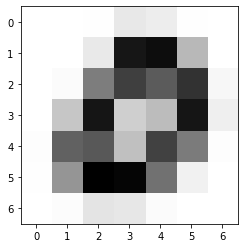

In [18]:
# Example data image
some_digit_image = X_train[np.random.randint(Nt)].reshape(img_len, img_len)
plt.imshow(some_digit_image, cmap="binary")
plt.show()

**Sweeping algorithm (in progress)**

To do: 
- Remove for loop over training data
- Optimize contractions to be computed in paralellel   

In [ ]:
# Set training data
X = X_train

# Set training labels
y = y_train

# The feature map with shape (Nt, N)
Phi = feature_map(X)

# Initialize MPS with N features and D bond dimension
mps = MPS(N, D)

for k in range(Nsweep):
    
    # Start from first site of the mps 
    for j in range(N):

        # Take sites j and j+1
        A1 = tn.Node(mps[j])
        A2 = tn.Node(mps[(j+1) % N])

        # calculate B which is the contraction of the two sites
        B = tn.contract(A1[2] ^ A2[0]).tensor

        # The projection Phit obtained when we remove A1 and A2
        Phit = projection(mps, Phi, j)  # Phi has shape (7,2,2,D,D)

        # Contraction of feature map with mps gives the cost
        f = decision(B, Phit) # f has shape(Nt,10)

        # Compute cost
        C = cost(f, y)
        
        # Computed gradient to update B
        dB = grad(Phit, y, f)
        B = B + lr * dB

        # Split updated B into two nodes to restore MPS form
        mps[j], mps[(j+1) % N] = split(B, Dmax)
        
        # At the end of the loop, mps[0] gets the index l back to start a new sweep
        
        if j % 10 == 0:
            accuracy = 0
            for n in range(Nt):
                if np.argmax(f[n]) == np.argmax(y[n]):
                    accuracy = accuracy + 1
            accuracy = accuracy/Nt

            # The feature map with shape (Nt, N)
            Phi_test = feature_map(X_test)
            A1 = tn.Node(mps[0])
            A2 = tn.Node(mps[1])
            B_test = tn.contract(A1[2] ^ A2[0]).tensor
            Phit_test = projection(mps, Phi_test, j) 
            f_test = decision(B, Phit_test) 

            test_accuracy = 0
            for n in range(Ny):
                if np.argmax(f_test[n]) == np.argmax(y_test[n]):
                    test_accuracy = test_accuracy + 1

            test_accuracy = test_accuracy/Ny
            print("Sweep %d,   MPS site %d,  Cost = %f" % (k, j, C)) 
            print("Training accuracy:", accuracy)
            print("Test accuracy:", test_accuracy)